Let's use the baby problem to show how exact POMDP methods work. We will use the `T`, `O`, and `update_belief` functions defined in the State Uncertainty notebook. These functions have been placed in the file "baby.jl" in this directory.

We also need to define the reward function according to the baby problem definition in the text.

In [1]:
include("baby.jl")

function R(s,a)
    r = 0.0
    if a == :feed
        r -= 5.0
    end
    if s == :hungry
        r -= 10.0
    end
    return r
end

R (generic function with 1 method)

When using the alpha vector representation of the value function, a set of alpha vectors $\Gamma$ is maintained and updated with each backup. To perform a Bellman backup at belief $b$, we create an alpha vector $\alpha_a$ for each action $a$. The entry for each state is

$$\alpha_a(s) = R(s,a) + \gamma \sum_s T(s,a,s')\sum_o O(a,s',o)\alpha_{ao}(s')\text,$$

where $\alpha_{ao}$ is the maximizing alpha vector at belief $b_{ao}$, the belief reached after taking action $a$ from $b$ and observing observation $o$. That is,

$$\alpha_{ao} = \text{argmax}_{\alpha \in \Gamma} \alpha^\top b_{ao}\text.$$

Each $\alpha_a$ is put into the set $\Gamma$.

In [2]:
# finds alpha vector in alphas that maximizes dot product with belief b
function argmax(b, alphas)
    best_value = -Inf
    best_alpha = alphas[1]
    
    for alpha in alphas
        alpha_value = b[:hungry]*alpha[:hungry] + b[:not_hungry]*alpha[:not_hungry]
        if alpha_value > best_value
            best_alpha = alpha
            best_value = alpha_value
        end
    end
    return best_alpha
end

function bellman_backup(b, alphas)
    for a in [:feed, :not_feed]
        alpha_a = Dict{Symbol, Float64}()
        for s in [:hungry, :not_hungry]
            sp_sum = 0.0
            for sp in [:hungry, :not_hungry]
                o_sum = 0.0
                for o in [:cry, :not_cry]
                    bao = update_belief(b,a,o)
                    alpha_ao = argmax(bao, alphas)
                    o_sum += O(a, sp, o) * alpha_ao[sp]
                end
                sp_sum += T(s,a,sp) * o_sum
            end
            alpha_a[s] = R(s,a) + 0.9 * sp_sum   # 0.9 is the discount factor
        end
        push!(alphas, alpha_a)
    end
end

bellman_backup (generic function with 1 method)

We will represent the alpha vectors with dictionaries to make the indexing clear.

The variable `alphas` is a vector of these alpha dictionaries. It is equivalent to $\Gamma$.



In [3]:
alphas = Dict{Symbol, Float64}[]

0-element Array{Dict{Symbol,Float64},1}

So how do we initialize the set of alpha vectors? We want a simple lower bound on the value function.

One way to get this is a "blind policy" that performs the same action every time. In the worst case, we immediately transition to the state that yields the worst immediate reward and stay there. So we pick the action that has the best worst-case performance (the best performance at its worst state) and take the infinite discounted sum:
$$
\frac{\max_a \min_s R(s,a)}{1 - \gamma}\text.
$$
In our case, this value is
$$
\frac{-10}{1 - 0.9}\text.
$$
We assign this value to every element in the alpha vector, so the initial alpha vector $\alpha_0$ is $[-100, -100]$.

In [4]:
push!(alphas, Dict(:hungry => -100.0, :not_hungry => -100) )    # alpha vector for feeding

1-element Array{Dict{Symbol,Float64},1}:
 Dict(:not_hungry=>-100.0,:hungry=>-100.0)

The file "alpha_plots.jl" handles will plot a set of alpha vectors for us.

Let's plot our original alpha vector.

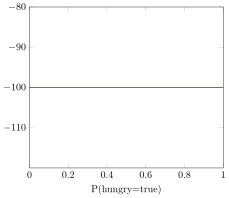

In [5]:
include("alpha_plots.jl")
plot(alphas)

Let's start from a uniform initial belief and perform a backup:

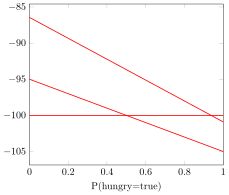

In [6]:
b0 = Dict(:hungry => 0.5, :not_hungry => 0.5)
bellman_backup(b0, alphas)
plot(alphas)

We see that two alpha vectors have been added. One of these vectors (the lower of the two new ones) is *dominated*, because it is never the maximal alpha vector. We can remove it.

In [7]:
alphas

3-element Array{Dict{Symbol,Float64},1}:
 Dict(:not_hungry=>-100.0,:hungry=>-100.0) 
 Dict(:not_hungry=>-95.0,:hungry=>-105.0)  
 Dict(:not_hungry=>-86.445,:hungry=>-100.9)

It is the second alpha vector, so we delete that index. We plot the resulting alpha vector set.

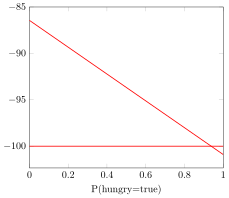

In [8]:
deleteat!(alphas, 2)
plot(alphas)

Deleting dominated alpha vectors is called sometimes called *pruning*. It is important to periodically prune the alpha vector set because we often iterate over all vectors. Keeping the set as small as possible improves computational efficiency.

Given the root (initial) belief, there are three possible new beliefs given the action selected and observation observed. If the baby is fed, we know that it is not hungry. If it isn't fed, the probabilities change depending on whether the baby cries or not.

We backup each of these child beliefs and then backup the root belief.

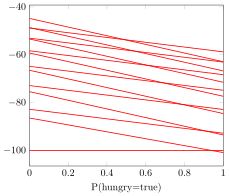

In [9]:
b1 = Dict(:hungry=> 0.0, :not_hungry=>1.0)    # if we feed the baby
b2 = update_belief(b0, :not_feed, :cry)       # if we don't feed the baby and it cries
b3 = update_belief(b0, :not_feed, :not_cry)   # if we don't feed the baby and it doesn't cry

bellman_backup(b1, alphas)
bellman_backup(b0, alphas)

bellman_backup(b2, alphas)
bellman_backup(b0, alphas)

bellman_backup(b3, alphas)
bellman_backup(b0, alphas)

plot(alphas)

There are two things to note. First, each backup provides more information, and the upper surface of the alpha vector set changes with this information. The upper surface determines the policy. Second, many alpha vectors are dominated. We did not prune in between the last series of updates, so we are carrying far more alpha vectors than we need to specify the policy.

The following set of alpha vectors is an equivalent policy, as the dominated vectors are removed.

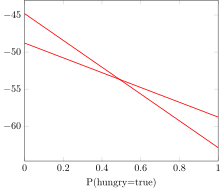

In [10]:
alphas = alphas[13:14]
plot(alphas)

To continue solving for the policy, we expand the belief tree to the children of the current beliefs. We then perform backups at the new beliefs up to the root.

Obviously, the complexity is exponential as the belief tree depth increases, so this process quickly stalls on most problems. As a result, many approximation methods have been developed.